In [2]:
import yaml
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from umap.umap_ import UMAP
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

/opt/homebrew/anaconda3/envs/IS/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [3]:
# Load YAML data
def load_yaml_articles(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        articles = yaml.safe_load(file)
    return articles


articles = load_yaml_articles('articles.yaml')

In [4]:
from urllib.parse import urlparse
import re

def extract_topics_from_url(url, skip_last_n=2):
    path = urlparse(url).path
    parts = [part for part in path.strip("/").split("/") if part]

    if len(parts) > skip_last_n:
        topics = parts[:-skip_last_n]
    else:
        topics = []

    # Replace hyphens with spaces, remove numbers if needed, clean up
    topics = [re.sub(r'[-_]+', ' ', topic) for topic in topics]

    return topics


In [5]:
# Assuming articles are loaded like this:
# articles = load_yaml_articles('articles.yaml')

for article in articles:
    article['url_topics'] = extract_topics_from_url(article['url'])

# Verify:
print(articles[0]['url_topics'])

['svet', 'preberite tudi']


In [6]:
# Extract representative texts from articles
def get_article_text(article):
    text_parts = [
        article.get('title', ''),
        article.get('lead', ''),
        ' '.join(article.get('paragraphs', [])),
    ]
    return ' '.join(text_parts)
    
# Prepare data
texts = [get_article_text(article) for article in tqdm(articles, desc="Processing articles")]


Processing articles: 100%|██████████| 29493/29493 [00:00<00:00, 175619.39it/s]


In [7]:
# ----------- TF-IDF Embeddings ----------- #
print("Generating TF-IDF embeddings...")
tfidf_vectorizer = TfidfVectorizer(
        max_features=20000,  # Increased for large dataset
        min_df=10,  # Ignore terms in fewer than 10 documents
        max_df=0.85,  # Ignore terms in more than 85% of documents
        ngram_range=(1, 2),  # Include both words and two-word phrases
    )
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

Generating TF-IDF embeddings...


In [8]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# TODO: report
# tfidf_dense = tfidf_matrix.toarray()

# # Reduce dimensionality to something manageable (e.g. 50D)
# pca = PCA(n_components=50, random_state=42)
# tfidf_pca = pca.fit_transform(tfidf_dense)

svd = TruncatedSVD(n_components=15, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100, random_state=42)
#tfidf_tsne_2d = tsne.fit_transform(tfidf_reduced)
tfidf_tsne_2d = tsne.fit_transform(tfidf_reduced)

### FILL EVERYTHING

In [10]:
import umap

# umap_50d = umap.UMAP(n_components=50, metric='cosine', random_state=42).fit_transform(tfidf_matrix)
#umap_2d = umap.UMAP(n_components=2, metric='cosine', random_state=42).fit_transform(tfidf_matrix)

In [11]:
#np.save("tfidf_umap_2d.npy", umap_2d)
umap_2d = np.load("tfidf_umap_2d.npy")

In [12]:
# np.save("tfidf_umap50d.npy", umap_50d)
umap_50d = np.load("tfidf_umap50d.npy")

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


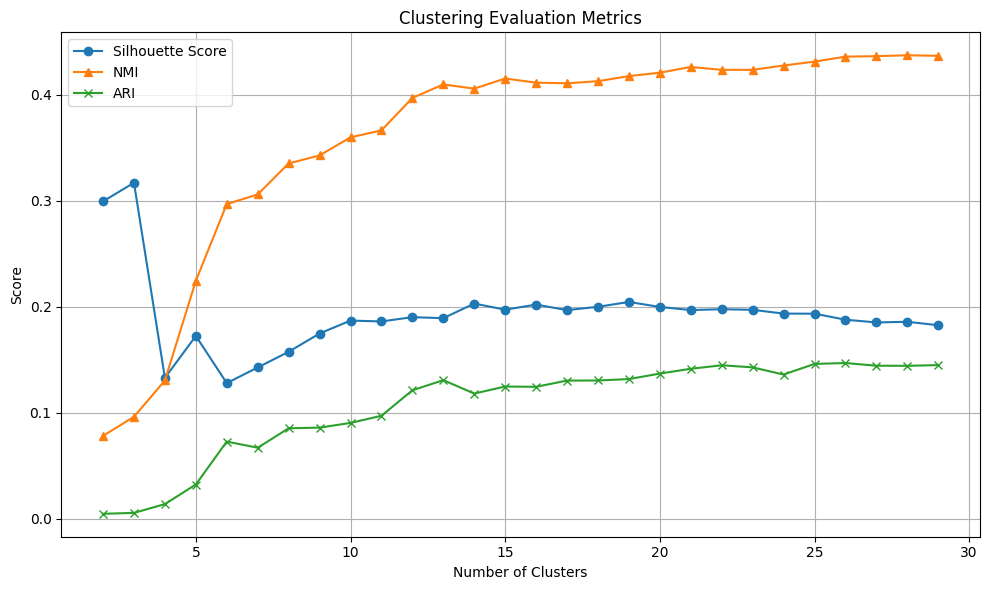

In [13]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt


def cluster_with_kmeans(embeddings, n_clusters=20, random_state=42):
    """
    Clusters the given embeddings using KMeans.

    Args:
        embeddings (np.ndarray): 2D array of shape (n_samples, n_features)
        n_clusters (int): Number of clusters to create
        random_state (int): For reproducibility

    Returns:
        clusters (np.ndarray): Cluster labels for each item
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    clusters = kmeans.fit_predict(embeddings)
    return clusters

# Example usage
tfidf_clusters = cluster_with_kmeans(tfidf_reduced, n_clusters=10)

topic_strings = [
    "/".join(article['url_topics']) if article['url_topics'] else "no-topic"
    for article in articles
]
le = LabelEncoder()
topic_labels = le.fit_transform(topic_strings)

# Evaluate clustering
def draw_graph():
    ari_score = []
    nmi_score = []
    silhouette = []
    chz = []

    for n in range(2, 30):
        tfidf_clusters = cluster_with_kmeans(tfidf_reduced, n_clusters=n)

        ari_score.append(adjusted_rand_score(topic_labels, tfidf_clusters))
        nmi_score.append(normalized_mutual_info_score(topic_labels, tfidf_clusters))
        silhouette.append(silhouette_score(tfidf_reduced, tfidf_clusters))
        #chz.append(calinski_harabasz_score(umap_25d, sbert_clusters))
        print(n)
    
    plt.figure(figsize=(10, 6))

    x = list(range(2, 30))
    plt.plot(x, silhouette, label='Silhouette Score', marker='o')
    #plt.plot(x, chz, label='Calinski-Harabasz', marker='s')
    plt.plot(x, nmi_score, label='NMI', marker='^')
    plt.plot(x, ari_score, label='ARI', marker='x')

    plt.xlabel("Number of Clusters")
    plt.ylabel("Score")
    plt.title("Clustering Evaluation Metrics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

draw_graph()

In [14]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import alphashape
from shapely.geometry import Polygon, MultiPolygon
import plotly.colors as pc
from itertools import cycle

def draw_single_plot(
    umap_embeddings,
    clusters,
    titles,
    keywords_per_cluster=None,
    categories=None,
    show_group_outlines=True,
    outline_opacity=0.05,
    alpha=5,
    title="Vizualizacija novic rtvslo.si"
):
    import re  # Needed for hex_to_rgb

    def hex_to_rgb(color):
        if color.startswith("rgb"):
            return tuple(map(int, re.findall(r'\d+', color)))
        color = color.lstrip('#')
        lv = len(color)
        return tuple(int(color[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

    def get_filtered_points(points, percentile=95):
        center = np.median(points, axis=0)
        dists = np.linalg.norm(points - center, axis=1)
        threshold = np.percentile(dists, percentile)
        return points[dists <= threshold]

    def fit_ellipse_to_points(points, scale=2.4477):
        pca = PCA(n_components=2)
        pca.fit(points)
        center = pca.mean_
        width, height = np.sqrt(pca.explained_variance_) * scale
        angle = np.degrees(np.arctan2(pca.components_[0, 1], pca.components_[0, 0]))

        t = np.linspace(0, 2 * np.pi, 100)
        ellipse_x = center[0] + width * np.cos(t) * np.cos(np.radians(angle)) - height * np.sin(t) * np.sin(np.radians(angle))
        ellipse_y = center[1] + width * np.cos(t) * np.sin(np.radians(angle)) + height * np.sin(t) * np.cos(np.radians(angle))
        return ellipse_x, ellipse_y

    def summarize_keywords(keywords_dict, short=True, max_words=5):
        tfidf = keywords_dict.get("tfidf", [])
        tfidf_preview = ", ".join(tfidf[:max_words])
        if short:
            return tfidf_preview
        else:
            lines = [
                "<b>Cluster Keywords</b>",
                "―" * 20,
                f"<b>tfidf</b>: {', '.join(tfidf[:10])}",
                "―" * 20,
                f"<b>keybert</b>: {', '.join(keywords_dict.get('keybert', [])[:10])}",
                f"<b>yake</b>: {', '.join(keywords_dict.get('yake', [])[:5])}",
            ]
            return "<br>".join(lines)

    # Generate short and full label maps
    if keywords_per_cluster:
        short_names = {
            cluster_id: summarize_keywords(keywords, short=True)
            for cluster_id, keywords in keywords_per_cluster.items()
        }
        hover_texts = {
            cluster_id: summarize_keywords(keywords, short=False)
            for cluster_id, keywords in keywords_per_cluster.items()
        }
    else:
        short_names = {}
        hover_texts = {}

    # Create main dataframe
    df = pd.DataFrame({
        'x': umap_embeddings[:, 0],
        'y': umap_embeddings[:, 1],
        'cluster': clusters.astype(str),
        'title': titles,
    })

    # Assign group label
    if keywords_per_cluster:
        df['group'] = [f"{int(c)}: {short_names.get(int(c), 'Unknown')}" for c in clusters]
    elif categories is not None:
        df['group'] = pd.Series(categories).astype(str)
    else:
        df['group'] = df['cluster']

    unique_groups = sorted(df['group'].unique())
    group_to_cluster = {g: int(g.split(":")[0]) for g in unique_groups}

    color_pool = (
        pc.qualitative.Plotly +
        pc.qualitative.D3 +
        pc.qualitative.Set1 +
        pc.qualitative.Set2 +
        pc.qualitative.Set3 +
        pc.qualitative.Pastel1 +
        pc.qualitative.Pastel2 +
        pc.qualitative.Dark24 +
        pc.qualitative.Alphabet
    )
    color_cycle = cycle(color_pool)
    group_to_color = {group: next(color_cycle) for group in unique_groups}

    fig = go.Figure()

    for group in unique_groups:
        sub_df = df[df['group'] == group]
        fig.add_trace(
            go.Scattergl(
                x=sub_df['x'],
                y=sub_df['y'],
                mode='markers',
                name=group,
                marker=dict(size=4, color=group_to_color[group]),
                legendgroup=group,
                showlegend=True,
                hoverinfo='skip',
            )
        )

        if show_group_outlines and len(sub_df) >= 5:
            points = sub_df[['x', 'y']].to_numpy(dtype=np.float32)
            filtered_points = get_filtered_points(points, percentile=80)

            if len(filtered_points) >= 5:
                ellipse_x, ellipse_y = fit_ellipse_to_points(filtered_points)

                rgb = hex_to_rgb(group_to_color[group])
                rgba_fill = f'rgba({rgb[0]},{rgb[1]},{rgb[2]},0.1)'

                fig.add_trace(
                    go.Scattergl(
                        x=ellipse_x,
                        y=ellipse_y,
                        mode='lines',
                        line=dict(color=group_to_color[group], width=1),
                        fill='toself',
                        fillcolor=rgba_fill,
                        name=group,
                        legendgroup=group,
                        hoverinfo='text',
                        text=[hover_texts.get(group_to_cluster[group], group)] * len(ellipse_x),
                        showlegend=False
                    )
                )

                # Add cluster ID label at center
                cluster_id = group_to_cluster[group]
                fig.add_annotation(
                    x=np.mean(filtered_points[:, 0]),
                    y=np.mean(filtered_points[:, 1]),
                    text=f"<b>#{cluster_id}: {len(points)}</b>",
                    showarrow=False,
                    font=dict(size=12, color="black"),
                    align="center",
                    bordercolor="black",
                    borderwidth=1,
                    borderpad=4,
                    bgcolor="white",
                    opacity=0.9
                )



    fig.update_layout(
        title=title,
        width=1200,
        height=800,
        xaxis_title="UMAP 1",
        yaxis_title="UMAP 2",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.35,
            xanchor="center",
            x=0.5,
            title=None,
            font=dict(size=10)
        ),
        margin=dict(t=80, b=80)
    )

    fig.show()


In [15]:
print(len(set(tfidf_clusters)))

10


In [16]:
import json

def load_combined_jsonl(filename="preprocessed_combined.jsonl"):
    with open(filename, "r", encoding="utf-8") as f:
        return [json.loads(line.strip()) for line in f if line.strip()]

# Example usage
preprocessed_texts = load_combined_jsonl()
print(f"✅ Loaded {len(preprocessed_texts)} preprocessed articles.")


✅ Loaded 29493 preprocessed articles.


In [17]:
tokenized_texts = [text.split() for text in preprocessed_texts]

In [ ]:
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# You should pass in a stopword list — ideally Slovene
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')

# Setup stopwords & lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('slovene'))
def extract_cluster_keywords(texts_tokenized, clusters, stop_words=list(stop_words), top_n=20, ngram_range=(1, 2)):
    """
    Extracts top n-grams (unigrams + bigrams) from preprocessed texts by cluster.
    """
    unique_clusters = np.unique(clusters[clusters >= 0])
    keywords_per_cluster = {}

    for cluster_label in unique_clusters:
        # cluster_texts = [texts[i] for i in range(len(texts)) if clusters[i] == cluster_label]
        # if not cluster_texts:
        #     continue
        cluster_texts = [preprocessed_texts[i] for i in range(len(texts_tokenized)) if clusters[i] == cluster_label]
        texts_raw = [texts[i] for i in range(len(texts_tokenized)) if clusters[i] == cluster_label]
        tokenized_cluster_texts = [text.split() for text in cluster_texts]
        cluster_titles = [articles[i]['title'] for i in range(len(texts_tokenized)) if clusters[i] == cluster_label]
        if not cluster_texts:
            continue

        # TF-IDF with stopword filtering and n-grams
        vectorizer = TfidfVectorizer(
            max_features=1000,
            stop_words=stop_words,
            ngram_range=ngram_range,
            token_pattern=r'\b\w{3,}\b',  # only tokens with 3+ letters
        )
        tfidf_matrix = vectorizer.fit_transform(cluster_texts)
        feature_array = np.array(vectorizer.get_feature_names_out())
        tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).ravel()

        # Top N terms by TF-IDF score
        top_indices = tfidf_scores.argsort()[::-1][:top_n]
        top_keywords = feature_array[top_indices]

        
        # YAKE (per-cluster single joined string)
        # yake_keywords = extract_yake_keywords(" ".join(cluster_texts))

        # # KeyBERT (per-cluster single joined string)
        # keybert_keywords = extract_keybert_keywords(" ".join(cluster_texts), stop_words)

        # # # NPMI (tokenized texts + cluster labels)
        # # npmi_keywords = extract_npmi_keywords(tokenized_cluster_texts)

        # print("tfidf: ", list(top_keywords))
        # print("yake: ", yake_keywords)
        # print("keybert: ", keybert_keywords)
        # print("npmi: ", npmi_keywords)
        
        # print("size of cluster:", len(cluster_texts))
        # for i in range(len(cluster_titles[:10])):
        #     print("----", cluster_titles[i])


        keywords_per_cluster[cluster_label] = {
            "tfidf": list(top_keywords),
            "keybert": [],#keybert_keywords,
            "yake": []#yake_keywords
        }

    return keywords_per_cluster

# Label from keywords
def keywords_to_sentence(keywords_obj, lang='sl'):
    for method, keywords in keywords_obj.items():
        keyword_line = ", ".join(keywords)
        cluster_text += f"{method} keywords: {keyword_line}\n"
    return cluster_text



[nltk_data] Downloading package punkt to /Users/matjeez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matjeez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/matjeez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
import numpy as np
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from keybert import KeyBERT
import yake
from nltk.corpus import stopwords
import nltk

# -------------------------------
# 2. YAKE Keyword Extraction
# -------------------------------
def extract_yake_keywords(text, top_n=20, language='sl'):
    kw_extractor = yake.KeywordExtractor(lan=language, top=top_n)
    keywords = kw_extractor.extract_keywords(text)
    return [kw for kw, _ in keywords]

# -------------------------------
# 3. KeyBERT Keyword Extraction
# -------------------------------
keybert_model = KeyBERT(model='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
def extract_keybert_keywords(text, stop_words, top_n=20):
    # print("text: ", text)
    keywords = keybert_model.extract_keywords(text, top_n=top_n, stop_words=stop_words)
    return [kw for kw, _ in keywords]

# -------------------------------
# 4. PMI/NPMI-Based Keyword Extraction (Coherence)
# -------------------------------
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from collections import defaultdict

def extract_npmi_keywords(cluster_docs, top_n=20):
    """
    Extract top N keywords from a list of tokenized documents using NPMI coherence.

    Parameters:
        cluster_docs (List[List[str]]): Tokenized documents for one cluster.
        top_n (int): Number of top keywords to extract.

    Returns:
        keywords (List[str]): Top N keywords.
    """
    if len(cluster_docs) < 3:
        return []

    # Create dictionary and corpus
    dictionary = Dictionary(cluster_docs)
    corpus = [dictionary.doc2bow(text) for text in cluster_docs]

    # Word frequency
    word_freq = defaultdict(int)
    for doc in cluster_docs:
        for word in doc:
            word_freq[word] += 1

    # Select top words by frequency
    top_words = sorted(word_freq, key=word_freq.get, reverse=True)[:top_n]
    topic = [[w] for w in top_words]  # CoherenceModel expects list of topics

    # Compute NPMI to rank them
    cm = CoherenceModel(
        topics=topic,
        texts=cluster_docs,
        corpus=corpus,
        dictionary=dictionary,
        coherence='c_npmi',
        topn=top_n
    )
    _ = cm.get_coherence()  # Optional: retrieve the average NPMI score
    return top_words



In [24]:
# categories = [
#     article['url_topics'][0] if len(article['url_topics']) >= 1 else "no-topic"
#     for article in articles
# ]
# categories = [
#     article['topics'] for article in articles
# ]
# categories = [
#     "/".join(article['url_topics'][:2]) if article['url_topics'] else "no-topic"
#     for article in articles
# ]

keywords_per_cluster = extract_cluster_keywords(tokenized_texts, tfidf_clusters)

draw_single_plot(
    umap_embeddings=tfidf_tsne_2d,
    clusters=tfidf_clusters,
    titles=None,
    keywords_per_cluster=keywords_per_cluster,
    show_group_outlines=True
)


In [ ]:
np.save("tfidf_clusters.npy", tfidf_clusters)
np.save("true_labels.npy", categories)